In [1]:
import numpy as np
import pandas as pd


In [2]:
df = pd.read_csv('./../data/preprocessed_matches.csv')
df.head()
df = df.rename(columns={ 'winner': 'winner_label', 'outcome': 'outcome_label' }) if 'winner' in df.columns else df
label_map = {'H_or_D':0,'A':1}

In [3]:
features = [
    'elo_home_pre','elo_away_pre','elo_diff_pre',
    'home_gf_roll','home_ga_roll','home_pts_roll',
    'away_gf_roll','away_ga_roll','away_pts_roll',
    'rest_days_home','rest_days_away','rest_days_diff',
    # 'h2h_avg_points_home', 'h2h_avg_points_away'
]

In [4]:
train_seasons = list(range(df['season'].min(), 2023))
test_seasons = list(range(2023,df['season'].max() +1))
train_seasons, test_seasons

([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], [2023, 2024, 2025])

In [5]:
train_df = df[df['season'].isin(train_seasons)].copy()
train_df.head()

,match_id,season,kickoff,home_team,home_team_id,home_score,away_team,away_team_id,away_score,outcome_label,...,home_pts_roll,away_gf_roll,away_ga_roll,away_pts_roll,h2h_avg_points_home,h2h_avg_points_away,rest_days_home,rest_days_away,rest_days_diff,target
0,803169,2015,2015-08-08 12:45:00,Manchester United,1,1,Tottenham Hotspur,6,0,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0
1,803170,2015,2015-08-08 15:00:00,Everton,11,2,Watford,57,2,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0
2,803162,2015,2015-08-08 15:00:00,Bournemouth,91,0,Aston Villa,7,1,A,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,1
3,803163,2015,2015-08-08 15:00:00,Norwich City,45,1,Crystal Palace,31,3,A,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,1
4,803167,2015,2015-08-08 15:00:00,Leicester City,13,4,Sunderland,56,2,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0


In [6]:
test_df = df[df['season'].isin(test_seasons)].copy()
test_df.head()

,match_id,season,kickoff,home_team,home_team_id,home_score,away_team,away_team_id,away_score,outcome_label,...,home_pts_roll,away_gf_roll,away_ga_roll,away_pts_roll,h2h_avg_points_home,h2h_avg_points_away,rest_days_home,rest_days_away,rest_days_diff,target
3040,2367538,2023,2023-08-11 20:00:00,Burnley,90,0,Manchester City,43,3,A,...,0.8,1.4,0.6,2.0,0.083333,2.833333,446.166667,75.145833,371.020833,1
3041,2367540,2023,2023-08-12 13:00:00,Arsenal,3,2,Nottingham Forest,17,1,H_or_D,...,1.8,1.8,1.6,1.6,1.500000,1.500000,75.854167,75.854167,0.000000,0
3042,2367544,2023,2023-08-12 15:00:00,Sheffield United,49,0,Crystal Palace,31,1,A,...,1.2,1.8,1.4,1.6,1.500000,1.500000,810.958333,75.937500,735.020833,1
3043,2367542,2023,2023-08-12 15:00:00,Everton,11,0,Fulham,54,1,A,...,1.6,2.0,1.6,1.4,1.166667,1.666667,75.937500,75.937500,0.000000,1
3044,2367541,2023,2023-08-12 15:00:00,Brighton and Hove Albion,36,4,Luton Town,102,1,H_or_D,...,1.4,1.5,1.5,1.5,1.000000,1.000000,75.937500,7.000000,68.937500,0


In [7]:
x_train = train_df[features]
y_train = train_df['target']

x_test = test_df[features]
y_test = test_df['target']

In [8]:
from notebooks.evaluator import evaluate
from sklearn.ensemble import RandomForestClassifier

def predict_random_forest():

    rf_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        class_weight='balanced',
    )

    rf_model.fit(x_train, y_train)
    #Predict with RandomForestClassifier the probability of H_or_D or A
    prob = rf_model.predict_proba(x_test)
    pred_labels = np.argmax(prob, axis=1)


    evaluate(y_test, prob, pred_labels, test_df, label_map, features, rf_model.feature_importances_)

logloss: 0.5794625230795484
accuracy: 0.7130144605116796
Confusion matrix (rows true, cols pred):
[[534  67]
 [191 107]]
Precision: 0.6757471264367816
Recall: 0.623789768729969


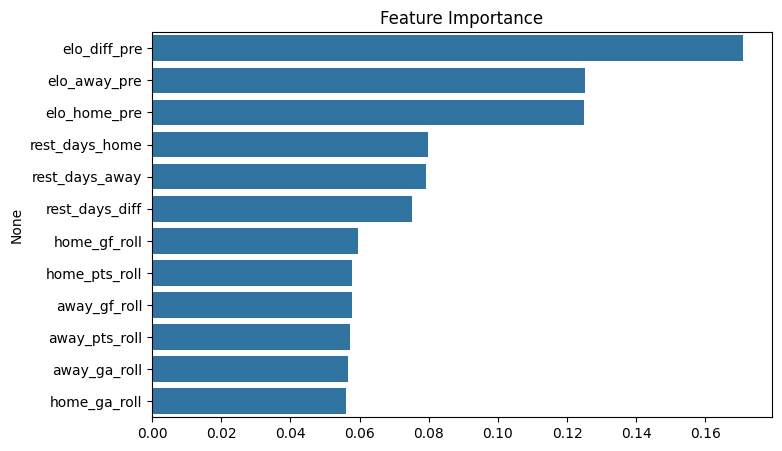

In [9]:
predict_random_forest()

In [10]:
import lightgbm as lgb
def predict_lightgbm():

    params = {
        'objective': 'multiclassova',
        'num_class': 2,
        'metric': 'multi_logloss',
        'verbosity': -1,
        'seed': 42,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 20
    }
    lgb_tr = lgb.Dataset(x_train, label=y_train)
    gbm = lgb.train(params, lgb_tr, num_boost_round=1000)
    model = gbm


    preds = model.predict(x_test)
    pred_labels = np.argmax(preds, axis=1)
    evaluate(y_test, preds, pred_labels, test_df, label_map, features, model.feature_importance(importance_type='gain'))

logloss: 0.8322065719534069
accuracy: 0.675194660734149
Confusion matrix (rows true, cols pred):
[[494 107]
 [185 113]]
Precision: 0.6205884321863704
Recall: 0.6005790126076227


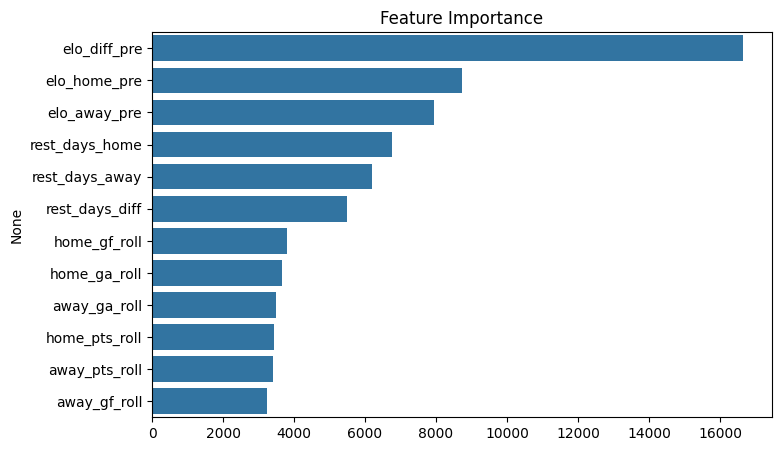

In [11]:
predict_lightgbm()

In [12]:
from xgboost import XGBClassifier
def predict_xgboost():

    xgb_model = XGBClassifier(
        n_estimators=5,
        num_class=2,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='multi:softprob',  # for multiclass probability output
        eval_metric='mlogloss'       # multi-class log loss
    )

    # Fit model
    xgb_model.fit(x_train, y_train)

    # Predict probabilities
    prob = xgb_model.predict_proba(x_test)
    pred_labels = np.argmax(prob, axis=1)
    feature_importances = xgb_model.get_booster().get_score(importance_type='gain')

    # Evaluate model
    evaluate(y_test, prob, pred_labels, test_df, label_map, features, feature_importances)

In [ ]:
predict_xgboost()

In [20]:
df = df[df['season'] != 2015]
df['season'].unique()

array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])

In [15]:
from sklearn.metrics import accuracy_score
seasons = df["season"].unique()
fold_results = []

model = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        class_weight='balanced',
    )



for i in range(1, len(seasons)):

    train_seasons = seasons[:i]
    test_seasons  = [seasons[i]]

    train_df = df[df["season"].isin(train_seasons)]
    test_df  = df[df["season"].isin(test_seasons)]

    X_train = train_df[features]
    y_train = train_df['target']
    X_test  = test_df[features]
    y_test  = test_df['target']

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    score = accuracy_score(y_test, preds)

    fold_results.append(score)
    print(f"Fold {i}: Train {train_seasons}, Test {test_seasons}, Score={score:.4f}")

print("Avg score:", np.mean(fold_results))


Fold 1: Train [2016], Test [2017], Score=0.7237
Fold 2: Train [2016 2017], Test [2018], Score=0.6974
Fold 3: Train [2016 2017 2018], Test [2019], Score=0.7105
Fold 4: Train [2016 2017 2018 2019], Test [2020], Score=0.6132
Fold 5: Train [2016 2017 2018 2019 2020], Test [2021], Score=0.7053
Fold 6: Train [2016 2017 2018 2019 2020 2021], Test [2022], Score=0.7132
Fold 7: Train [2016 2017 2018 2019 2020 2021 2022], Test [2023], Score=0.7184
Fold 8: Train [2016 2017 2018 2019 2020 2021 2022 2023], Test [2024], Score=0.6913
Fold 9: Train [2016 2017 2018 2019 2020 2021 2022 2023 2024], Test [2025], Score=0.7143
Avg score: 0.6985730597381757
